In [1]:
import os
import pandas as pd
from pandas.core.groupby import groupby
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as si
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy as sp
import scipy
from datetime import datetime, timedelta
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from itertools import combinations
import researchpy as rp
from matplotlib.colors import to_rgba

In [2]:
dc = pd.read_csv('DCEW_updated_7aug23.csv',parse_dates = [2], infer_datetime_format = True)
dc.tail(2)

,Sample_Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev
134,1605,DC-C2E-1605,2023-05-25,-122.904922,0.483,-16.237666,0.120
135,1608,DC-C2M-1608,2023-05-25,-123.575051,1.730,-16.449515,0.352


In [3]:
#remove ID numbers from site names
dc['Site_no'] = dc.Site_ID.str[3:6]
dc['Type'] = 'DC'
dc.head()

#take out -
dc = dc.replace(['LR-'],'LR')
dc = dc.replace(['MR-'],'MR')
dc = dc.replace(['UR-'],'UR')
dc = dc.replace(['LG-'],'LG')
dc['Site_no'].unique()

array(['C1E', 'LR', 'MR', 'UR', 'LG', 'C2E', 'C2M', 'C1W'], dtype=object)

In [4]:
# create a list of our conditions to place site_no with elevation
cond = [
    (dc['Site_no'] == 'LG'),
    (dc['Site_no'] == 'LR'),
    (dc['Site_no'] == 'MR'),
    (dc['Site_no'] == 'UR'),
    (dc['Site_no'] == 'C2M'),
    (dc['Site_no'] == 'C2E'),
    (dc['Site_no'] == 'C1E'),
    (dc['Site_no'] == 'C1W')
    ]
# create a list of the values we want to assign for each condition
#LG= 1036 C2m= 1143 c2e= 1158 c1w= 1347 c1e= 1335 
#estimating rose is UR = 1064.5m MR = 1062.5m LR = 1060.5m
val = ['1036','1060', '1062', '1064', '1143', '1158', '1335','1347']

# create a new column and use np.select to assign values to it using our lists as arguments
dc['elevation'] = np.select(cond, val)

[Text(0.5, 0, ' DCEW Sites'), Text(0, 0.5, '$\\mathregular{D^{18}}$O')]

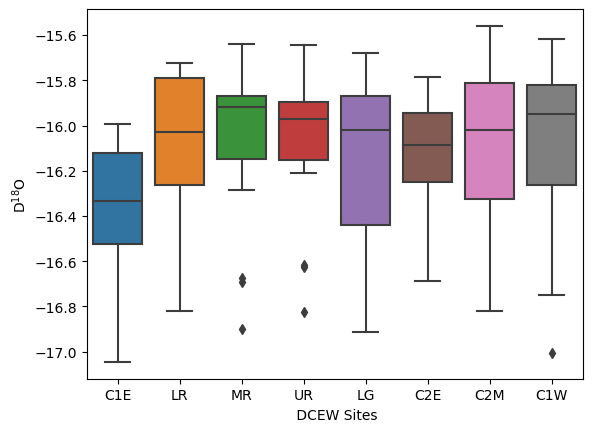

In [5]:
#box plot of DCEW sites, not ordered
hue_order =  ['LG-','LR-','MR-','UR-','C2M','C2E','C1E','C1W'] 
sns.boxplot(data=pd.concat([dc]),
            x='Site_no', y='D_18O',hue_order=hue_order).set(xlabel=' DCEW Sites',ylabel='$\mathregular{D^{18}}$O')

# Paired T-Test for DCEW Sites

In [6]:
rng = np.random.default_rng()

DC_D18O = dc['D_18O']
DC_Sites = dc['Site_ID']

#stats.ttest_rel(DC_D18O, DC_Sites)

dc[['Site_ID','D_18O']].describe()   
stats.shapiro(dc['D_18O'])

ShapiroResult(statistic=0.9310740828514099, pvalue=3.2914633720793063e-06)

In [7]:
#stats.shapiro(dc['Site_ID'])
stats.ttest_rel(dc['D_18O'],dc['Site_ID']=='C1E')

TtestResult(statistic=-523.9376958875115, pvalue=3.284265615633558e-225, df=135)

In [8]:
import statsmodels.stats.multicomp as mc

comp1 = mc.MultiComparison(dc['D_18O'], dc['Site_no'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind)
#tbl
#p < 0.05 

## MCW Isotope Dataset

In [9]:
df = pd.read_csv('MCW_Processed_Iso_NOV23.csv',parse_dates = [2], infer_datetime_format = True)
df.head(3)

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev
0,1,BC,2022-10-05,-126.803089,0.905,-16.459499,0.1660
1,2,MC,2022-10-05,-121.245698,0.503,-16.055768,0.0923
2,3,BC,2022-10-27,-124.454618,0.553,-16.515137,0.1370


In [10]:
#Seperate column for type of sample collection, rain v snow v stream (MC v BC)
df['Type'] = df.Site_ID.str[:2]
#Seperate site nomber 1 - 10
df['Site_no'] = df.Site_ID.str[3:5]
df['Site_no'] = df['Site_no'].apply(pd.to_numeric)
#Seperate rain vs snow to their own columns
df['Rain'] = df.Type.equals('RC')
df['Snow'] = df.Type.equals('IB')

In [11]:
# Set precip values to only rain or snow, not stream samples
df['D_18O_Precip'] = np.where((df['Type'] == 'RC')|
                               (df['Type'] == 'IB'), df['D_18O'], np.nan)

df['D_2H_Precip'] = np.where((df['Type'] == 'RC') |
                               (df['Type'] == 'IB'), df['D_2H'], np.nan)

### Global and Local Meteoric Water Lines

In [12]:
# δ2H = 7.40 * δ18O – 2.176  local meteoric water line BOise, ID
# δ2H = 8 * δ18O + 10 GMWL
m_global = 8 
b_global = 10
x_global = np.linspace(-6,-25) # constructs a numpy array of [0.0, 1.0, ... 10.0]

m_local = 7.4
b_local = -2.176

(-130.0, -110.0)

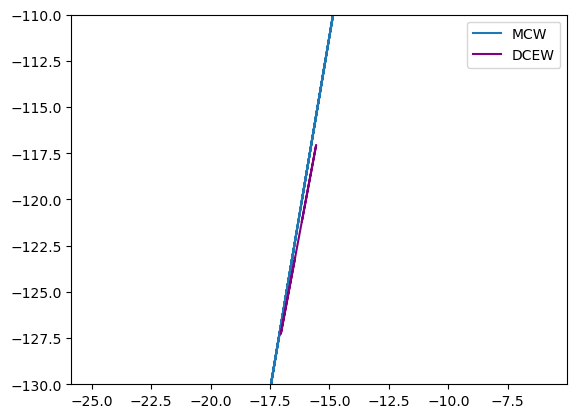

In [13]:
# Mores Creek D_O18 Values 
x = df['D_18O_Precip']
y = df['D_2H_Precip']

#obtain m (slope) and b(intercept) of linear regression line
#m, b = np.polyfit(x, y, 1)

idx = np.isfinite(x) & np.isfinite(y)
m, b = np.polyfit(x[idx], y[idx], 1)

plt.plot(x, m*x+b, label='MCW')

# Dry Creek D_18O values & regression line 
x_dc = dc['D_18O']
y_dc = dc['D_2H']
c,d = np.polyfit(x_dc, y_dc, 1)
plt.plot(x_dc, c*x_dc+d, linestyle='solid', color ='purple', label='DCEW')
plt.legend()

#zoom up on dry creek
plt.ylim(-130, -110)

In [14]:
#local isotope dataset from 2013
dd = pd.read_csv('DCEW_Danny_Isotopes.csv',parse_dates = [1], infer_datetime_format = True)

dd.rename(columns={'Site_ID': 'Type'}, inplace=True)
dd.head()

,Type,Collection_Date,D_2H_Precip,D_18O_Precip
0,Lower Deer Point,2009-11-13,-150.39,-19.06
1,Lower Deer Point,2010-01-13,-84.22,-11.37
2,Lower Deer Point,2010-01-20,-131.73,-15.63
3,Lower Deer Point,2010-01-20,-136.24,-17.27
4,Lower Deer Point,2010-03-29,-118.34,-15.84


MC LinregressResult(slope=7.6604946982391695, intercept=3.741922975039401, rvalue=0.9943885800734976, pvalue=3.3712397367671415e-150, stderr=0.0661028476168636, intercept_stderr=1.062496968865452)
r_squared_MCW = 0.9888086481805868


Text(0.5, 1.0, 'updated')

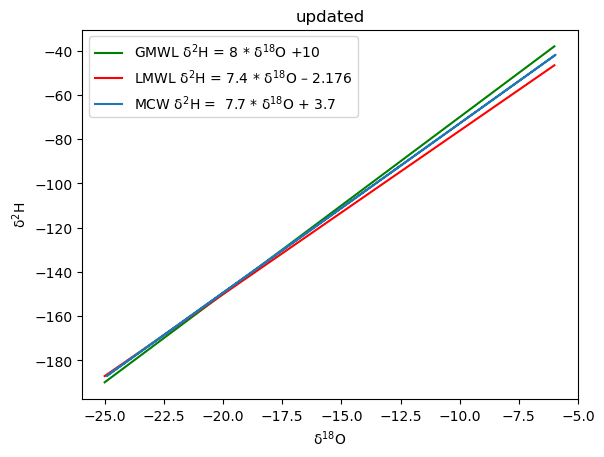

In [15]:
#GMWL & LMWL 
# order of operation
plt.plot(x_global, m_global * x_global + b_global, linestyle='solid', color="g",
         label='GMWL $\mathregular{δ^{2}}$H = 8 * $\mathregular{δ^{18}}$O +10')
plt.plot(x_global, m_local * x_global + b_local, linestyle='solid', color='r',
         label='LMWL $\mathregular{δ^{2}}$H = 7.4 * $\mathregular{δ^{18}}$O – 2.176')

# Mores Creek D_O18 Values 
x = df['D_18O_Precip']
y = df['D_2H_Precip']
#plt.scatter(x,y,s=10,color='gray')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x[idx], y[idx], 1)

#add linear regression line to scatterplot
plt.plot(x[idx], m*x[idx]+b, label='MCW $\mathregular{δ^{2}}$H =  7.7 * $\mathregular{δ^{18}}$O + 3.7')

plt.ylabel('$\mathregular{δ^{2}}$H')
plt.xlabel('$\mathregular{δ^{18}}$O')
plt.legend()
# Dry Creek D_18O values & regression line 
#x_dc = dc['D_18O']
#y_dc = dc['D_2H']
#m, b = np.polyfit(x_dc, y_dc, 1)
#c, d = np.polyfit(x_dc, y_dc, 1)
#plt.plot(x_dc, c*x_dc+d, linestyle='solid', color ='purple', linewidth=2.0, label='R2 DCEW = ')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_dc, y_dc)
slope, intercept, r_mcw, p_value, std_err = scipy.stats.linregress(x[idx], y[idx])

print('MC',linregress(x[idx],y[idx]))
#print('DC',linregress(x_dc,y_dc))

r_squared_MCW = r_mcw ** 2
print('r_squared_MCW =', r_squared_MCW)

plt.title('updated')
#take all stream data and dry creek only show mores creek preicp - clarify only precip data 
#add in equations for all of them 
#take out stream data
#do I need R2 or p value in the legend to or just the equation?

#### Local MWL Points vs MCW Points 

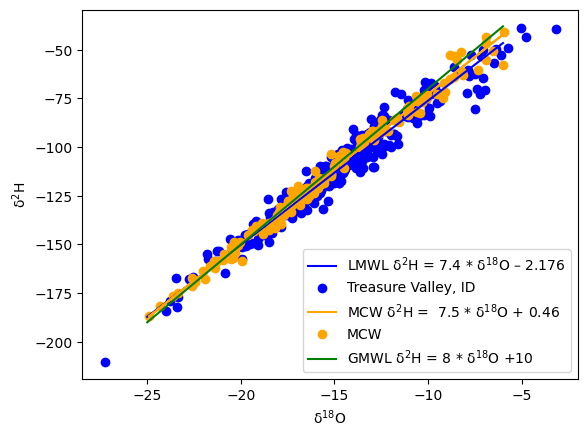

In [16]:
#Treasure valley poinst from 2013 combined with Mores Creek from 2022-2023
plt.plot(x_global, m_local * x_global + b_local, linestyle='solid', color='blue',
         label='LMWL $\mathregular{δ^{2}}$H = 7.4 * $\mathregular{δ^{18}}$O – 2.176')

plt.scatter(dd['D_18O_Precip'],dd['D_2H_Precip'], label='Treasure Valley, ID', color='blue')

#add linear regression line to scatterplot
plt.plot(x[idx], m*x[idx]+b, color='orange', label='MCW $\mathregular{δ^{2}}$H =  7.5 * $\mathregular{δ^{18}}$O + 0.46')

plt.scatter(df['D_18O'], df['D_2H'], label='MCW', color='orange')
#sns.scatterplot(x="D_18O", y="D_2H", data=dd)

#adding GMWL
plt.plot(x_global, m_global * x_global + b_global, linestyle='solid', color="g",
         label='GMWL $\mathregular{δ^{2}}$H = 8 * $\mathregular{δ^{18}}$O +10')

plt.ylabel('$\mathregular{δ^{2}}$H')
plt.xlabel('$\mathregular{δ^{18}}$O')
plt.legend()

### Distribution Plot D18O

In [17]:
TV = pd.concat([df, dd]).sort_index()
TV['D_18O_Precip'].dropna(inplace=True)

TV['Type'].unique()

array(['BC', 'Lower Deer Point', 'MC', 'RC', 'IB', 'Lower Weather',
       'Mountain View HS', 'Taft Elementary', 'Treeline',
       'Washington Elementary'], dtype=object)

In [18]:
def Site (row):
   if row['Type'] == 'MC' :
      return 'MCW'
   if row['Type'] == 'BC' :
      return 'MCW'
   if row['Type'] == 'IB' :
      return 'MCW'
   if row['Type'] == 'RC' :
      return 'MCW'
   if row['Type'] == 'Lower Deer Point' :
      return 'TV'
   if row['Type'] == 'Lower Weather' :
      return 'TV'
   if row['Type'] == 'Mountain View HS' :
      return 'TV'
   if row['Type'] == 'Taft Elementary' :
      return 'TV'
   if row['Type'] == 'Treeline' :
      return 'TV'
   if row['Type'] == 'Washington Elementary' :
      return 'TV'


TV['Site'] = TV.apply (lambda row: Site(row), axis=1)
TV

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev,Type,Site_no,Rain,Snow,D_18O_Precip,D_2H_Precip,Site
0,1.0,BC,2022-10-05,-126.803089,0.905,-16.459499,0.1660,BC,NaN,False,False,NaN,NaN,MCW
0,NaN,NaN,2009-11-13,NaN,NaN,NaN,NaN,Lower Deer Point,NaN,NaN,NaN,-19.06,-150.39,TV
1,NaN,NaN,2010-01-13,NaN,NaN,NaN,NaN,Lower Deer Point,NaN,NaN,NaN,-11.37,-84.22,TV
1,2.0,MC,2022-10-05,-121.245698,0.503,-16.055768,0.0923,MC,NaN,False,False,NaN,NaN,MCW
2,3.0,BC,2022-10-27,-124.454618,0.553,-16.515137,0.1370,BC,NaN,False,False,NaN,NaN,MCW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,NaN,NaN,2012-03-14,NaN,NaN,NaN,NaN,Washington Elementary,NaN,NaN,NaN,-15.78,-123.41,TV
315,NaN,NaN,2012-03-19,NaN,NaN,NaN,NaN,Washington Elementary,NaN,NaN,NaN,-14.55,-113.26,TV
316,NaN,NaN,2012-04-15,NaN,NaN,NaN,NaN,Washington Elementary,NaN,NaN,NaN,-15.73,-122.18,TV
317,NaN,NaN,2012-04-17,NaN,NaN,NaN,NaN,Washington Elementary,NaN,NaN,NaN,-11.99,-93.90,TV


In [19]:
TVMC = pd.read_csv('MCW_Practice_File.csv',parse_dates = [1], infer_datetime_format = True)


def Site_ID (row):
   if row['Site_ID'] == 'MC' :
      return 'MCW'
   if row['Site_ID'] == 'BC' :
      return 'MCW'
   if row['Site_ID'] == 'IB' :
      return 'MCW'
   if row['Site_ID'] == 'RC' :
      return 'MCW'
   if row['Site_ID'] == 'Lower Deer Point' :
      return 'TV'
   if row['Site_ID'] == 'Lower Weather' :
      return 'TV'
   if row['Site_ID'] == 'Mountain View HS' :
      return 'TV'
   if row['Site_ID'] == 'Taft Elementary' :
      return 'TV'
   if row['Site_ID'] == 'Treeline' :
      return 'TV'
   if row['Site_ID'] == 'Washington Elementary' :
      return 'TV'


TVMC['Type'] = TVMC.apply (lambda row: Site_ID(row), axis=1)
TVMC

,Site_ID,Collection_Date,D_2H,D_18O,Unnamed: 4,Unnamed: 5,Type
0,RC,2022-10-27,-92.796701,-12.540525,NaN,NaN,MCW
1,RC,2022-10-27,-95.549245,-13.497653,NaN,NaN,MCW
2,RC,2022-10-27,-104.588535,-14.756808,NaN,NaN,MCW
3,RC,2022-10-27,-104.535681,-14.562412,NaN,NaN,MCW
4,RC,2022-10-27,-119.535791,-15.940431,NaN,NaN,MCW
...,...,...,...,...,...,...,...
468,Washington Elementary,2012-03-14,-123.410000,-15.780000,NaN,NaN,TV
469,Washington Elementary,2012-03-19,-113.260000,-14.550000,NaN,NaN,TV
470,Washington Elementary,2012-04-15,-122.180000,-15.730000,NaN,NaN,TV
471,Washington Elementary,2012-04-17,-93.900000,-11.990000,NaN,NaN,TV


r_value = 0.9698433533505579
TV+MC LinregressResult(slope=7.388881538442984, intercept=-1.422616314862978, rvalue=0.9848062516812929, pvalue=0.0, stderr=0.06003561681981066, intercept_stderr=0.9257484001390026)


Text(0.5, 1.0, 'updated')

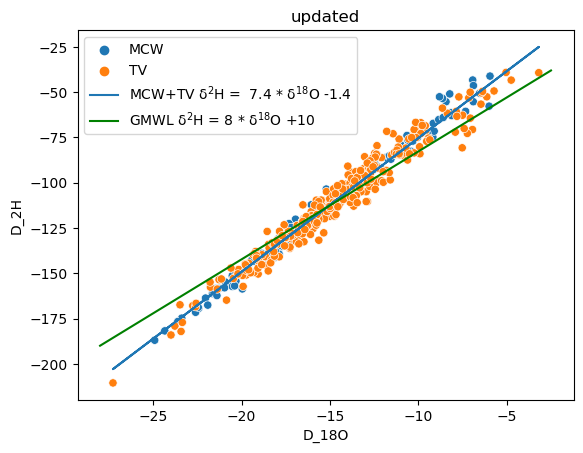

In [20]:
#Plot Treasure Valley D18O Distribution
#sns.displot(TV, x="D_18O_Precip", label='TV', hue='Site',kind='kde')

#MCW D18O Distribution
#sns.displot(df, x="D_18O_Precip",label='MCW', kind='kde')


#sns.displot(TV, x="D_18O_Precip", kind='kde')

#plt.scatter(TVMC['D_18O'], TVMC['D_2H'])
sns.scatterplot(x='D_18O', y='D_2H', data=TVMC, hue='Type')

x1= TVMC['D_18O']
y1 = TVMC['D_2H']

#idx = np.isfinite(x) & np.isfinite(y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x1, y1, 1)

#add MCW + TV linear regression line to scatterplot
plt.plot(x1, m*x1+b, label='MCW+TV $\mathregular{δ^{2}}$H =  7.4 * $\mathregular{δ^{18}}$O -1.4')

#adding GMWL
xx_global = np.linspace(-2.5,-28)
plt.plot(xx_global, m_global * x_global + b_global, linestyle='solid', color="g",
         label='GMWL $\mathregular{δ^{2}}$H = 8 * $\mathregular{δ^{18}}$O +10')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x1, y1)

print('r_value =',r_value**2)

plt.legend()
print('TV+MC',linregress(x1,y1))

#fig, ax =plt.subplots(1,2)
#sns.displot(df["D_18O"], ax=ax[0])
#sns.displot(dd["D_18O"], ax=ax[1])
#plt.show()

#maybe try concatenating and then hue of mc vs tv
#sns.displot(penguins, x="flipper_length_mm", hue="species")

# do another displot for fraction of streamflow (x = D018, y = count)color code warm(red) and blue(cold) 


#double check precip values and stream samples removed
# double check mcmwl and tv for only precip (checked)
plt.title('updated')

C:\Users\grena\anaconda3\lib\site-packages\seaborn\utils.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
C:\Users\grena\anaconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
C:\Users\grena\anaconda3\lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


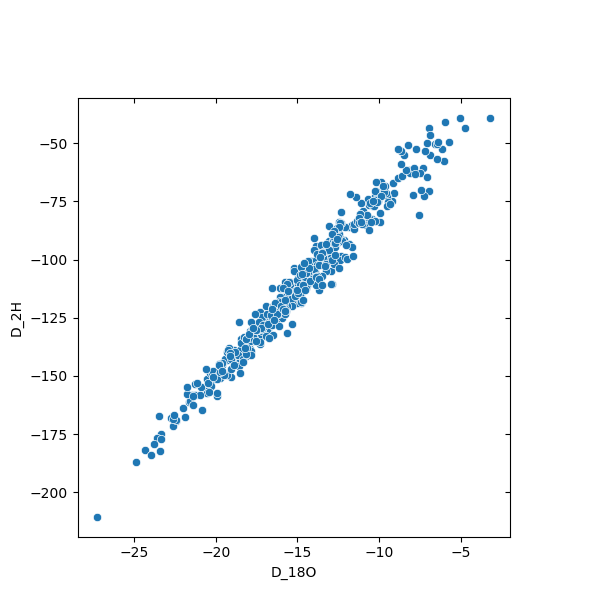

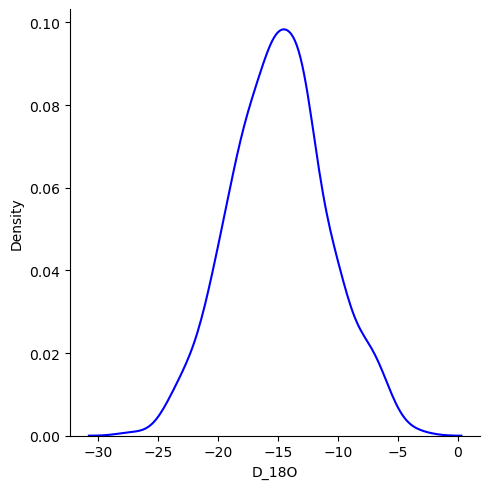

In [21]:
g=sns.JointGrid(x=x1, y=y1, data=TVMC, space=0)

g = g.plot_joint(sns.scatterplot, cmap="Blues_d")
sns.displot(TVMC["D_18O"], color="b", kind='kde', ax=g.ax_marg_x)

#shorten the y axis on dis plot and use inkscape to add it to the top of x margin

In [22]:
#t-test for distribution of TV and MCW
comp1 = mc.MultiComparison(TV['D_18O'], TV['Site'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind)
tbl
#p < 0.05 

group1,group2,stat,pval,pval_corr,reject
MCW,TV,nan,nan,nan,False


### Add a new MWL for TV and MCW

x = TV['D_18O_Precip']
y = TV['D_2H_Precip']

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x[idx], y[idx], 1)

#add linear regression line to scatterplot
plt.plot(x[idx], m*x[idx]+b, label='MCW $\mathregular{δ^{2}}$H =  7.5 * $\mathregular{δ^{18}}$O + 0.46')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_dc, y_dc)
print('r_value =',r_value)
r_squared_MCW = r_value ** 2

### Stream isotopes
###  MCW & DCEW 

In [23]:
# D18O Mean Values for rain, snow, streams, total 
#resue this to calculate means if datafile changes

#df.drop(df[df['Type'] == 'IB'].index, inplace = True)
#df.drop(df[df['Type'] == 'RC'].index, inplace = True)
#df.drop(df[df['Type'] == 'MC'].index, inplace = True)
#df.drop(df[df['Type'] == 'BC'].index, inplace = True)
means = df['D_18O'].mean()
print('D_18O Mean =', means) 
# BC =  -16.8767 changed to -16.708
# MC = -16.6340 changed to -16.467
# RC = -13.3648 changed to -11.985
# IB = -19.1158 remained the same 

#std_dev mean # need to double check these use the mixing model file to get std 
# RC = 2.608
# IB = 2.254
#Warm std =  2.598
#Cold std =  2.427

D_18O Mean = -15.725107648514854


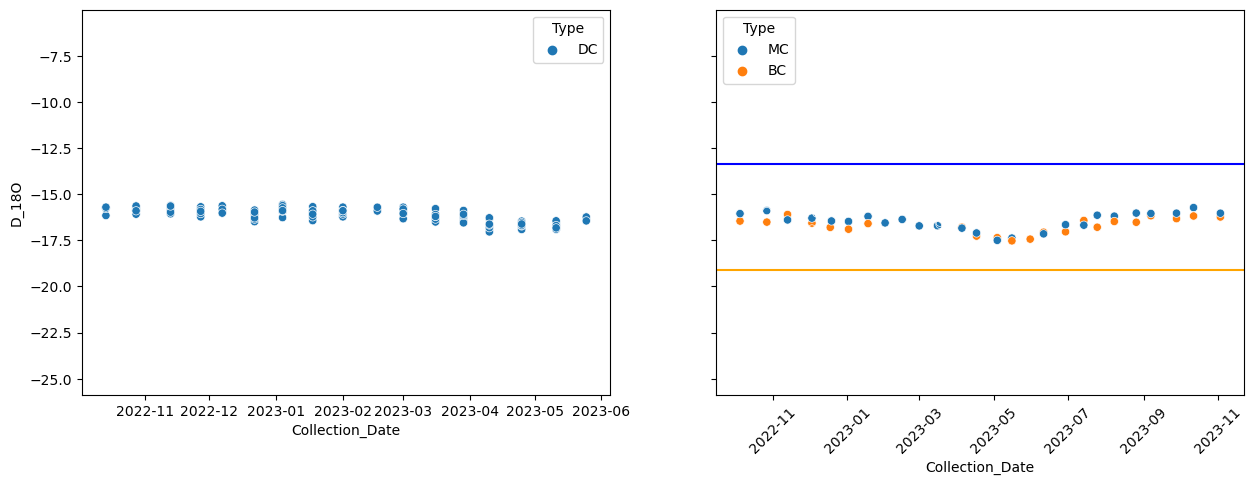

In [24]:
#Side by side view
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15, 5))
#set axis limits -22.5, -10
hue_order = ['MC', 'BC']

#Dry Creek
sns.scatterplot(x="Collection_Date", y="D_18O", data=dc, hue="Type", ax=ax1)#, hue_order=hue_order)
plt.xticks(rotation=45)
#plt.ylim(-22.5, -10)

#Mores Creek
sns.scatterplot(x="Collection_Date", y="D_18O", data=df, hue="Type", hue_order=hue_order,ax=ax2)

#SNOW Average
#add average for ib_avg
plt.axhline(y=-19.12, color='orange', linestyle='-')
left, bottom, width, height = (-2, -21.72, 33,5.216)
rect=mpatches.Rectangle((left,bottom),width,height,alpha=0.1,facecolor="orange")
plt.gca().add_patch(rect)

#RAIN Average
#add average for rc_avg
plt.axhline(y=-13.36, color='b', linestyle='-')
left, bottom, width, height = (-2,-15.614, 33, 4.5)
rect=mpatches.Rectangle((left,bottom),width,height,alpha=0.1,facecolor="blue")
plt.gca().add_patch(rect)
plt.xticks(rotation=45);

In [25]:
#Concatenate DC and MC datasets
s3= pd.concat([df, dc]).sort_index()
s3['Type'].unique()

array(['BC', 'DC', 'MC', 'RC', 'IB'], dtype=object)

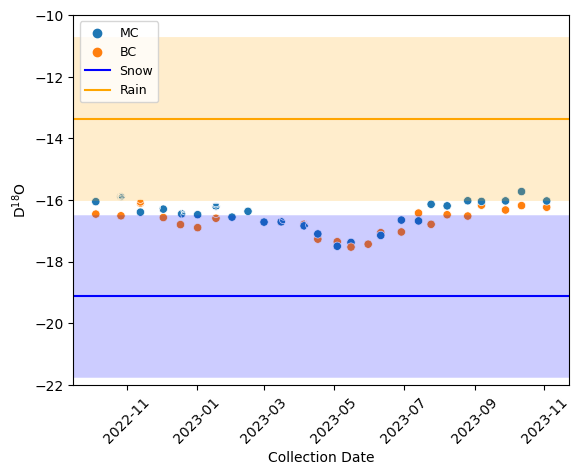

In [26]:
#Mores Creek Stream data compared to rain v snow averages
#hue_order = ['MC', 'BC','DC']
hue_order = ['MC', 'BC']
sns.scatterplot(x='Collection_Date', y='D_18O', data=s3,
                hue='Type',hue_order=hue_order).set(ylabel='$\mathregular{D^{18}}$O', xlabel='Collection Date')

#SNOW
#add average for ib_avg
plt.axhline(y=-19.12, color='b', linestyle='-', label='Snow')
plt.axhline(y=-13.36, color='orange', linestyle='-',label='Rain') 
plt.axhline(y=-19.12, color='b', linestyle='-', linewidth = '117', alpha=0.2)
#plt.axhline(y=-21.7, color='orange', linestyle='-')
#plt.axhline(y=-16.5, color='orange', linestyle='-')
#left, bottom, width, height = (0, -21.72, 43,5.216)
#rect=mpatches.Rectangle((left,bottom),width,height,alpha=0.1,facecolor="orange")
#plt.gca().add_patch(rect)

#RAIN
#add average for rc_avg
plt.axhline(y=-13.36, color='orange', linestyle='-',linewidth = '118',alpha=0.2) 
#plt.axhline(y=-15.97, color='b', linestyle='-') 
#plt.axhline(y=-10.75, color='b', linestyle='-')

#left= 0
#bottom= -15.614
#height = 4.5
#rect=mpatches.Rectangle((left,bottom),width,height,alpha=0.1,facecolor="blue")
#plt.gca().add_patch(rect)

plt.legend(loc='upper left',prop={'size': 9})
plt.xticks(rotation=45)
plt.ylim(-22,-10)
plt.show();

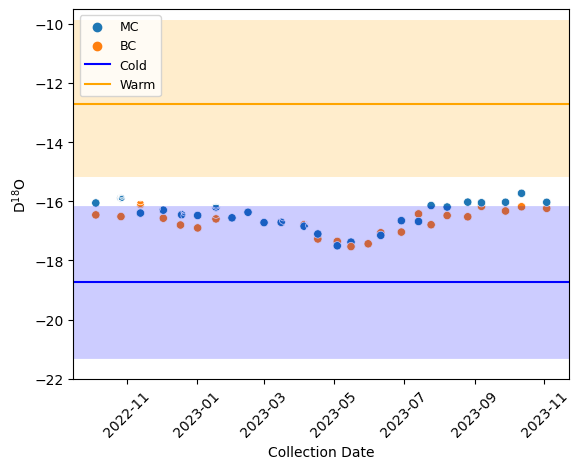

In [27]:
# Cold vs warm

#Mores Creek Stream data compared to rain v snow averages
hue_order = ['MC', 'BC']
sns.scatterplot(x='Collection_Date', y='D_18O', data=s3,
                hue='Type',hue_order=hue_order).set(ylabel='$\mathregular{D^{18}}$O', xlabel='Collection Date')

#Cold average 
plt.axhline(y=-18.73, color='b', linestyle='-', label='Cold')
#Warm average 
plt.axhline(y=-12.72, color='orange', linestyle='-',label='Warm') 

#STD shade

#Cold std =  2.427
plt.axhline(y=-18.73, color='b', linestyle='-', linewidth = '110', alpha=0.2)

#Warm std =  2.598
plt.axhline(y=-12.5, color='orange', linestyle='-',linewidth = '113',alpha=0.2) 

plt.legend(loc='upper left',prop={'size': 9})
plt.xticks(rotation=45)
plt.ylim(-22,-9.5)
plt.show();

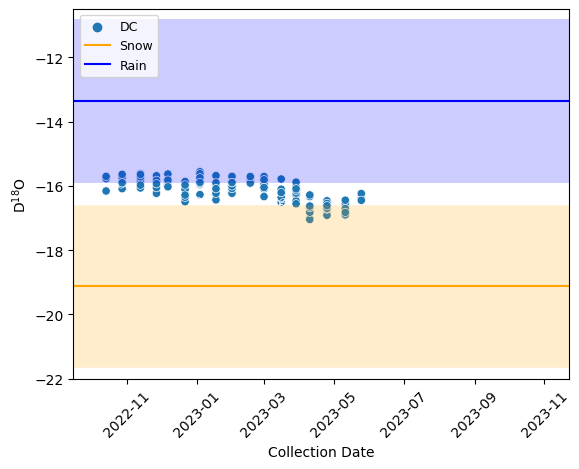

In [28]:
#Dry Creek data compared to MCW rain vs snow averages
hue_order = ['DC']
sns.scatterplot(x='Collection_Date', y='D_18O', data=s3,
                hue='Type',hue_order=hue_order).set(ylabel='$\mathregular{D^{18}}$O', xlabel='Collection Date')

#SNOW
#add average for ib_avg
plt.axhline(y=-19.12, color='orange', linestyle='-', label='Snow')
plt.axhline(y=-13.36, color='b', linestyle='-',label='Rain') 
plt.axhline(y=-19.12, color='orange', linestyle='-', linewidth = '117', alpha=0.2)


#RAIN
#add average for rc_avg
plt.axhline(y=-13.36, color='b', linestyle='-',linewidth = '118',alpha=0.2) 

plt.legend(loc='upper left',prop={'size': 9})
plt.xticks(rotation=45)
plt.ylim(-22,-10.5)
plt.show();

### Elevation vs precipiation MCW

[Text(0.5, 0, 'Site Number'), Text(0, 0.5, '$\\mathregular{D^{18}}$O')]

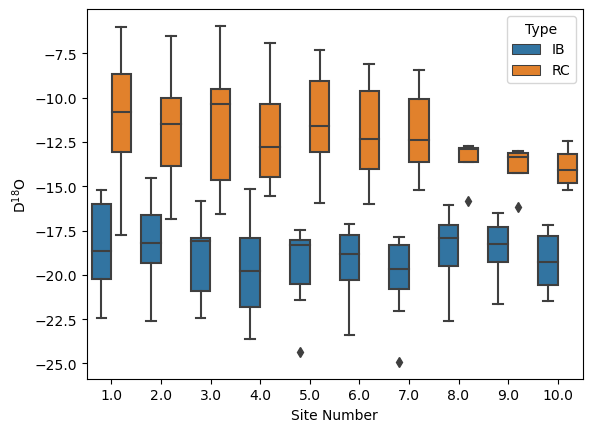

In [29]:
#Rain vs snow by site / elevation
hue_order = ['IB', 'RC']
sns.boxplot(data=pd.concat([df]),
            x='Site_no', y='D_18O',
            hue='Type',hue_order=hue_order).set(xlabel='Site Number',
                                                ylabel='$\mathregular{D^{18}}$O'
                                                )

# box plot cold v warm season sites

In [30]:
# Cold v warm change the dates!!! 
df['Cold_7'] = np.where((df['Collection_Date'] >= '2022-11-03') |
                        (df['Collection_Date'] < '2023-05-03'), df['D_18O_Precip'], np.nan) 
df['Warm_7'] = np.where((df['Collection_Date']  < '2022-11-03') |
df

SyntaxError: incomplete input (4180355101.py, line 5)

In [ ]:
df['Season'] = np.where((df['Collection_Date']  < '2022-11-03') |
                        (df['Collection_Date']  >= '2023-04-22'),'Warm','Cold')

In [ ]:
#Cold vs warm (7 days+) by site / elevation
hue_order = ['Cold','Warm']
#hue_order = ['Warm_7']
sns.boxplot(data=df,
            x='Site_no', y='D_18O_Precip',
            hue='Season', hue_order = hue_order).set(xlabel='Site Number', ylabel='$\mathregular{D^{18}}$O')


# +- 2 deg C

In [ ]:
# Cold v warm 2+_
df['Cold_2plus'] = np.where((df['Collection_Date'] >= '2022-11-07') &
                        (df['Collection_Date'] < '2023-04-22'), df['D_18O_Precip'], np.nan) 
df['Warm_2minus'] = np.where((df['Collection_Date']  < '2022-11-08') |
                        (df['Collection_Date']  >= '2023-04-23'),df['D_18O_Precip'], np.nan)

print('cold',df['Cold_2plus'].count())
print('warm',df['Warm_2minus'].count())


In [ ]:
# Cold v warm
#Cold -2 for greater than 7 days
#df['Cold_2minus'] = np.where((df['Collection_Date'] >= '2022-11-07') |
                        #(df['Collection_Date'] < '2023-04-23'), df['D_18O_Precip'], np.nan) 
# warm +2 greater than 7 days 
#df['Warm_2plus'] = np.where((df['Collection_Date']  < '2022-11-07') |
                       # (df['Collection_Date']  >= '2023-04-23'),df['D_18O_Precip'], np.nan)
#df.head(5)

In [ ]:
df['Season_2'] = np.where((df['Collection_Date']  <= '2022-11-07') |
                        (df['Collection_Date']  <= '2023-04-23'),'Warm_2plus','Cold_2minus')

#Cold vs warm (7 days+) by site / elevation with 2+-
hue_order = ['Cold_2minus','Warm_2plus']
#hue_order = ['Warm_7']
sns.boxplot(data=df,
            x='Site_no', y='D_18O_Precip',
            hue='Season_2', hue_order = hue_order).set(xlabel='Site Number', ylabel='$\mathregular{D^{18}}$O')


Assign elevations

In [ ]:
# create a list of our conditions
conditions = [
    (df['Site_no'] == 1.0),
    (df['Site_no'] == 2.0),
    (df['Site_no'] == 3.0),
    (df['Site_no'] == 4.0),
    (df['Site_no'] == 5.0),
    (df['Site_no'] == 6.0),
    (df['Site_no'] == 7.0),
    (df['Site_no'] == 8.0),
    (df['Site_no'] == 9.0),
    (df['Site_no'] == 10.0),
    (df['Site_no'] == 'NaN')
    ]
# create a list of the values we want to assign for each condition
values = [922,1160,1266,1455,1755,1780,1860,2036,2145,2316,'NaN']
#treeline + BC
# LG+MC USGS
#Snotel Bogus + MC

# create a new column and use np.select to assign values to it using our lists as arguments
df['elevation'] = np.select(conditions, values)

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

print(zero_to_nan(values))

#set string to numeric
df['elevation'] = df['elevation'].apply(pd.to_numeric)

# display updated DataFrame
df.head(2)

In [ ]:
#BC v MC precipiation samples

BC = df[df['Type'].isin(['BC'])].copy()
BC['Type'].dtype
BC['Type'] = pd.Categorical(BC['Type'], ['BC'])
BC['Type'].dtype

MC = df[df['Type'].isin(['MC'])].copy()
MC['Type'].dtype
MC['Type'] = pd.Categorical(MC['Type'], ['MC'])
MC['Type'].dtype

f, axs = plt.subplots(1,2, figsize=(15,4),sharey=True)
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 45)
      
p1 = sns.scatterplot(data=MC, x='Collection_Date', y='D_18O', hue='Type',ax=axs[0],
                     palette=['crimson']).set(ylabel='$\mathregular{D^{18}}$O')
p2 = sns.scatterplot(data=BC, x='Collection_Date', y='D_18O', hue='Type',ax=axs[1])

#BC average = -16.88
#   std = 0.39
plt.axhline(y=-16.88, color='b', linestyle='-',linewidth=2)
left, bottom, width, height = (-2, -17.27, 30,0.78)
rect=mpatches.Rectangle((left,bottom),width,height,alpha=0.1,facecolor="blue")
plt.gca().add_patch(rect)
#MC avg = -16.63
#   std = 0.435759066
axs[0].add_patch(mpatches.Rectangle((-2,-17.07),30,0.88,linewidth=1,alpha=0.1,facecolor='red'))
axs[0].add_patch(mpatches.Rectangle((-2,-16.63),30,0,linewidth=2,edgecolor='r',facecolor='none'))

print([x for x in ax1.get_xticks()])

## Individual Site Precip values

In [ ]:
#site = df[df['Type'].isin(['IB','RC'])].copy()
#site['Type'].dtype
#site['Type'] = pd.Categorical(site['Type'], ['IB','RC'])
#site['Type'].dtype
g = sns.catplot(data=df, x='Collection_Date', y="D_18O", hue="Type", col="Site_no",col_wrap=3, s=50)
g.set_xlabels('')
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
plt.subplots_adjust(hspace=0.3)
plt.show()

#need series of rain 

#add in appendix more easily readable 

In [ ]:
hue_order = ('RC','IB')
g = sns.lmplot(data=df, x='elevation', 
               y='D_18O_Precip', hue='Type', 
               hue_order=hue_order).set(ylabel='$\mathregular{D^{18}}$O',
                                        xlabel='Elevation',
                                        title='Mores Creek Elevation Trends')#,line_kws={'color': 'r'},
             # height=3.5, aspect=1.5,palette=['crimson']).set(ylabel='$\mathregular{D^{18}}$O')
#sns.scatterplot(data=pd.concat([df]),
 #           x='elevation', y='D_18O',style='Type').set(xlabel='Elevation (m)',ylabel='$\mathregular{D^{18}}$O') # after y hue='Type',
            #fit linear relationship : plot only snow and 2nd plot for only rain and see relationship
#sns.scatterplot(data=df, x='elevation', y='D_18O_Precip', hue='Type', hue_order=hue_order).set(ylabel='$\mathregular{D^{18}}$O', xlabel='Elevation',
                                                                                             #title='Mores Creek Elevation Trends')
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['elevation'], data['elevation'])
    ax = plt.gca()
    ax.text(0.9, .7, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

#create regplot snow
p = sns.regplot(data=Snow, x=df.elevation, y=df.D_18O,label='Snow',
                 scatter_kws={"color": "blue"}, line_kws={"color": "blue"})
plt.legend(fontsize=10, ncol=2)

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#display slope and intercept of regression equation
print('Intercept:',intercept,'  Slope:', slope, '  R-Value:',r)

#create regplot
p = sns.regplot(data=Rain, x=df.elevation, y=df.D_18O,label='Rain',
                 scatter_kws={"color": "red"}, line_kws={"color": "red"}).set(ylabel='$\mathregular{D^{18}}$O')
plt.legend(fontsize=10, ncol=2)

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#display slope and intercept of regression equation
print('Intercept:',intercept,'  Slope:', slope, '  R-Value:',r)

In [ ]:
#create new columns with data with isotope values only from rain, snow, and stream 
df['D_18O_Rain'] = np.where(df['Type'] == 'RC', df['D_18O'], np.nan)
df['D_18O_Snow'] = np.where(df['Type'] == 'IB', df['D_18O'], np.nan)
df['D_18O_streams'] = np.where(df['Type'] == 'MC', df['D_18O'],
                               np.where(df['Type'] == 'BC', df['D_18O'], np.nan))

df.head() 

In [ ]:
em = df.groupby(['Site_no', 'Type'],as_index=False,sort=False).mean().groupby(['D_18O_Snow']).mean()#.plot(kind='bar')

er = df.groupby(['Site_no', 'Type'],as_index=False,sort=False).mean().groupby(['D_18O_Rain']).mean()#.plot(kind='bar')

et = df.groupby(['Site_no'],as_index=False,sort=False).mean().groupby(['D_18O_Precip']).mean()


In [ ]:
sns.scatterplot(data = et, x = 'elevation', y = 'D_18O_Precip').set(ylabel='$\mathregular{D^{18}}$O',
                                                                    xlabel='Elevation',
                                                                    title='Mores Creek Avg Precip Values')
#sns.pointplot(data=et, x="elevation", y="D_18O_StDev")

#sns.pointplot(data=et, x="elevation", y="D_18O_Precip", errorbar="sd")
#plt.errorbar(et["elevation"], y[, yerr=yerrd,fmt="o", color="r")

In [ ]:
#average D_18O values at every Site 
#rain
sns.scatterplot(data = er, x = 'elevation', y = 'D_18O_Rain')
xx = er['elevation']
yy = er.index
a, c = np.polyfit(xx, yy, 1)
plt.plot(xx, a*xx+c,color='blue', label='RC $\mathregular{R^{2}}$ = 0.33, pvalue=0.08 ')

#snow
sns.scatterplot(data = em, x = 'elevation', y = 'D_18O_Snow')
x = em['elevation']
y= em.index
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b,color='orange', label='IB $\mathregular{R^{2}}$ = 0.07,pvalue=0.46')

plt.legend(loc='center')
plt.ylabel('$\mathregular{D^{18}}$O')
plt.xlabel('Elevation')
#plt.title('MCW Altitude Effect')

print('Snow',linregress(x,y))
print('Rain',linregress(xx,yy))
# calculate R squared value 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
r_squared_snow = r_value**2
print('r_squared_snow =', r_squared_snow)


slope, intercept, r_value_rain, p_value, std_err = scipy.stats.linregress(xx,yy)
r_squared_rain = r_value_rain**2
print('r_squared_rain =', r_squared_rain)
#rain value is sig with p value of .08
# not snow with 0.08

#add std dev to all points 
#figure 4 in pp

In [ ]:
#plt.errorbar(em['elevation'], em['D_18O'], yerr=em['D_18O_StDev'])
et

In [ ]:
#average site D_18O Values for both rain and snow
#values = [922,1160,1266,1455,1755,1780,1860,2036,2145,2316,'NaN']
yd = np.array([(-16.16),(-15.74),(-17.22),(-16.5),(-17.97),(-17.06),(-17.9),(-17.63),(-17.75),(-18.01)])
xd = np.array([926,1160,1266,1455,1755,1780,1860,2036,2145,2316])
yerrd = np.array([0.2,0.15,0.2,0.15,0.17,0.17,0.17,0.2,0.14,0.15])
#yerrd = int('0.2','0.15','0.2','0.15','0.17','0.17','0.17','0.2','0.14','0.15'
           
plt.errorbar(xd, yd, yerr=yerrd,fmt="o", color="r")

#coeff = np.polyfit(xd,yd,1)
#coeff

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(xd, yd, 1)

#add linear regression line to scatterplot
plt.plot(xd, m*xd+b,color='gray', label='$\mathregular{δ^{18}}O$ = -14.7x – 0.0015')
plt.legend()
print('Site Average',linregress(xd,yd))
plt.xlabel('Elevation (m)')
plt.ylabel('$\mathregular{D^{18}}$O Average')
#plt.title('Mores Creek Avg Precip Values')

slope, intercept, r_value_avg, p_value, std_err = scipy.stats.linregress(xd,yd)
r_squared_avg = r_value_avg**2
print('r_squared_avg sites =', r_squared_avg)
;

print('R2 =0.7, pvalue=0.002')
lapserate = slope * 1000
lapserate
#Slope without 8-10 slope=-0.00190315
#change r squared value
#elevation change for form of precipitation values creates a sig relationship when rain and snow are added together across elevation
#pull out lapse rate = slope look at dannys example, screenshot and put in slide

In [ ]:
#fig, ax = plt.subplots(figsize=(9,5))
#sns.lineplot(x=xd, y=yd, ci=yerrd)# err_style='bars')
#sns.despine()
#plt.show()

## Snotel Data 
### x= Temperature, x= Relative Humidiy
### 1. Two week average
### 2. precipitation length average

when have more time, create code to pull averages between each sample

In [ ]:
df['Collection_Date'].unique()

In [ ]:
st = pd.read_csv('Snotel_Temp_2023.csv',parse_dates = [0], infer_datetime_format = True)
st1 = st.set_index('Date')#,inplace=True)
st1.head()

In [ ]:
#z = #need temp before date not after 
a = st1['2022-10-05' : '2022-10-27'] # account for oct 27th 
b = st1['2022-10-28' : '2022-11-13'] # 
c = st1['2022-11-14' : '2022-12-03']
d = st1['2022-12-04' : '2022-12-19']
e = st1['2023-01-06' : '2023-01-18']
f = st1['2023-01-19' : '2023-02-01']
g = st1['2023-02-02' : '2023-02-15']
h = st1['2023-02-16' : '2023-03-01']
i = st1['2023-03-02' : '2023-03-18']
j = st1['2023-03-19' : '2023-04-05']
k = st1['2023-04-06' : '2023-04-17']
l = st1['2023-04-18' : '2023-05-04']
m = st1['2023-05-05' : '2023-05-16']
n = st1['2023-05-17' : '2023-05-31']
o = st1['2023-06-01' : '2023-06-11']
p = st1['2023-06-12' : '2023-06-29']

print('a',a.mean())
#print('b',b.mean())

merge = pd.merge_asof(a, b, on='Date')
print (merge)

st[st['Date'].between('2022-10-05','2022-10-27')]['Temp_c'].mean()

In [ ]:
weeks=st1.index.week
weekly_avg=st1.groupby(weeks).mean()

In [ ]:
#df.drop(df[df['Type'] == 'BC'].index, inplace = True)
#df.drop(df[df['Type'] == 'MC'].index, inplace = True)

x = df['Temp_c_two_week'] #plt.scatter(x,y,s=10,c='Type')
y = df['D_18O']
p1 = sns.scatterplot(data=df, x='Temp_c_two_week', y='D_18O',hue='Type')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot
plt.plot(x, m*x+b,color='gray',label='R2= 0.54') #add r 2 auto

plt.xlabel('Avg Biweekly Temp (C)')
plt.legend()
linregress(x,y)
plt.legend()
plt.ylabel('$\mathregular{D^{18}}$O')


slope, intercept, r_value_temp, p_value, std_err = scipy.stats.linregress(x,y)
r_squared_temp = r_value_temp**2
print('r_squared_temp =', r_squared_temp);

### Sensativity Analysis for Cold v Warm

### Snotel Data
### Elevation: 6100 ft / 1859 m (eq site: 7)

In [ ]:
#Snotel Mores Creek Pass
sn1 = pd.read_csv('SN_WaterYear_2023.csv',parse_dates = [0], infer_datetime_format = True)
sn = sn1.set_index('Date')#,inplace=True)
sn[300:340]
#take average between set dates for temp

In [ ]:
sn['discrete precip'] = np.diff(sn['PREC_Accum_in'], prepend=0)
sn['discrete precip'].iloc[0] = 0 
#sn['discrete precip'].plot()
#sn['discrete precip'].unique()
sn;

In [ ]:
sn = sn[sn['discrete precip'] > 0]
sn.head(3)

In [ ]:
sn['TAVG_degC ']
sn['cold_season'] = sn['TAVG_degC ' ] < 0 # can i write cold for 10 days in a row?
#otherwise just have this equal to past a certain date or cold season

#2022-11-03 first day below 0 followed by over 20 days
# first day over 0 followed by 7+ rest of days = 2023-04-22

sn[0:40]
x = sn.index #plt.scatter(x,y,s=10,c='Type')
y = sn['TAVG_degC ']
plt.plot(x,y)
plt.xticks(rotation = 45);

In [ ]:
a = sn['2022-10-05' : '2022-10-27']['TAVG_degC '].mean() # leave space after snotel data
b = sn['2022-10-28' : '2022-11-13']['TAVG_degC '].mean()
c = sn['2022-11-14' : '2022-12-03']['TAVG_degC '].mean()
d = sn['2022-12-04' : '2022-12-19']['TAVG_degC '].mean()
q = sn['2022-12-20' : '2023-01-05']['TAVG_degC '].mean()
e = sn['2023-01-06' : '2023-01-18']['TAVG_degC '].mean()
f = sn['2023-01-19' : '2023-02-01']['TAVG_degC '].mean()
g = sn['2023-02-02' : '2023-02-15']['TAVG_degC '].mean()
h = sn['2023-02-16' : '2023-03-01']['TAVG_degC '].mean()
i = sn['2023-03-02' : '2023-03-18']['TAVG_degC '].mean()
j = sn['2023-03-19' : '2023-04-05']['TAVG_degC '].mean()
k = sn['2023-04-06' : '2023-04-17']['TAVG_degC '].mean()
l = sn['2023-04-18' : '2023-05-04']['TAVG_degC '].mean()
m = sn['2023-05-05' : '2023-05-16']['TAVG_degC '].mean()
n = sn['2023-05-17' : '2023-05-31']['TAVG_degC '].mean()
o = sn['2023-06-01' : '2023-06-11']['TAVG_degC '].mean()
p = sn['2023-06-12' : '2023-06-29']['TAVG_degC '].mean()

temp = [a,b,c,d,q,e,f,g,h,i,j,k,l,m,n,o,p]
temp; # make sure is same length as do18, 
#it doesn't need to be because I added the average temp to every day between sampling perionds

In [ ]:
#df.drop(df[df['Type'] == 'BC'].index, inplace = True)
#df.drop(df[df['Type'] == 'MC'].index, inplace = True)

In [ ]:
x = df['avg_precip_Temp'] #plt.scatter(x,y,s=10,c='Type')
y = df['D_18O']
p1 = sns.scatterplot(data=df, x='avg_precip_Temp', y='D_18O',hue='Type')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot
plt.plot(x, m*x+b,color='gray', label='R2= 0.62')

plt.ylabel('$\mathregular{D^{18}}$O')
plt.xlabel('Avg Temp (C) during Precip Accum')
linregress(x,y)
plt.legend()
slope, intercept, r_value_temp, p_value, std_err = scipy.stats.linregress(x,y)
r_squared_temp = r_value_temp**2
print('r_squared_temp =', r_squared_temp);

## Town Creek
### Relative Humidity
### Meta Data = 4500 ft : 1372 m (eq to site 3-4)
#### 43° 56' 00" 115° 55' 00"

In [ ]:
t = pd.read_csv('Town_Creek_metdata.csv',parse_dates = [0], infer_datetime_format = True)
tc = t.set_index('Date ')
tc.head(3)
# temp only up to October 9th saves as Town_Creek_metdata_Temp_only

In [ ]:
#xx = tc['2022-10-01' : '2022-10-04']['avg_rel_humidity'].mean()
aa = tc['2022-10-05' : '2022-10-27']['avg_rel_humidity'].mean() 
bb = tc['2022-10-28' : '2022-11-13']['avg_rel_humidity'].mean()
cc = tc['2022-11-14' : '2022-12-03']['avg_rel_humidity'].mean()
dd = tc['2022-12-04' : '2022-12-19']['avg_rel_humidity'].mean()
qq = tc['2022-12-20' : '2023-01-05']['avg_rel_humidity'].mean()
ee = tc['2023-01-06' : '2023-01-18']['avg_rel_humidity'].mean()
ff = tc['2023-01-19' : '2023-02-01']['avg_rel_humidity'].mean()
gg = tc['2023-02-02' : '2023-02-15']['avg_rel_humidity'].mean()
hh = tc['2023-02-16' : '2023-03-01']['avg_rel_humidity'].mean()
ii = tc['2023-03-02' : '2023-03-18']['avg_rel_humidity'].mean()
jj = tc['2023-03-19' : '2023-04-05']['avg_rel_humidity'].mean()
kk = tc['2023-04-06' : '2023-04-17']['avg_rel_humidity'].mean()
ll = tc['2023-04-18' : '2023-05-04']['avg_rel_humidity'].mean()
mm = tc['2023-05-05' : '2023-05-16']['avg_rel_humidity'].mean()
nn = tc['2023-05-17' : '2023-05-31']['avg_rel_humidity'].mean()
oo = tc['2023-06-01' : '2023-06-11']['avg_rel_humidity'].mean()
pp = tc['2023-06-12' : '2023-06-29']['avg_rel_humidity'].mean()

rel_humidity = [aa,bb,cc,dd,qq,ee,ff,gg,hh,ii,jj,kk,ll,mm,nn,oo,pp]
tc.head()
#df.head()

In [ ]:
x = df['avg_rel_hum'] #plt.scatter(x,y,s=10,c='Type')
y = df['D_18O']
p1 = sns.scatterplot(data=df, x='avg_rel_hum', y='D_18O',hue='Type')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot
plt.plot(x, m*x+b,color='gray', label='R2= 0.23')
plt.legend()
plt.ylabel('$\mathregular{D^{18}}$O')
plt.xlabel('Avg Relative Humidity during Precip Accum')
linregress(x,y)
slope, intercept, r_value_rh, p_value, std_err = scipy.stats.linregress(x,y)
r_squared_rh = r_value_rh**2
print('r_squared_rh =', r_squared_rh);

### Sensativity Analysis for Cold vs Warm

In [ ]:
s3['Site_no'].unique()

In [ ]:
def Stream_Sites (row):
   if row['Type'] == 'MC' :
      return 'MC'
   if row['Type'] == 'BC' :
      return 'BC'
   if row['Site_no'] == 'C1E' :
      return 'C1E'
   if row['Site_no'] == 'LR' :
      return 'LR'
   if row['Site_no'] == 'MR' :
      return 'MR'
   if row['Site_no'] == 'UR' :
      return 'UR'
   if row['Site_no'] == 'C1W' :
      return 'C1W'
   if row['Site_no'] == 'C2E' :
      return 'C2E'
   if row['Site_no'] == 'C2M' :
      return 'C2M'
   if row['Site_no'] == 'LG' :
      return 'LG'

In [ ]:
s3['Stream_Sites'] = s3.apply (lambda row: Stream_Sites(row), axis=1)
s3

In [ ]:
#hue_order =  ['LG','LR','MR','UR','C2M','C2E','C1E','C1W','MC','BC'] 
sns.boxplot(data=pd.concat([s3]),
            x='Stream_Sites', y='D_18O',hue = 'Stream_Sites',
            order=['LG','LR','MR','UR','C2M','C2E','C1E','C1W','MC','BC'],dodge=False 
           ).set(xlabel=' Stream Sampling Sites (Oct 2022 - Jul 2023)',
                 ylabel='$\mathregular{D^{18}}$O')
plt.legend([],[], frameon=False);

### Boise Airport = 875 m (Site 1)
### Town Creek = 1371 m (Site 3-4)
### Snotel = 1859 m (Site 7)
### BOgus = 1932 m (Site 8)
### Pilot Peak = 2482 m (Site 10)
#### values = [922,1160,1266,1455,1755,1780,1860,2036,2145,2316,'NaN']

In [ ]:
wx = pd.read_csv('WX.csv',parse_dates = [0], infer_datetime_format = True)
#wx = w.set_index('Date')
#wx.drop(columns=None)
wx.head()

In [ ]:
grouped = wx.groupby(pd.Grouper(key='Date ', freq='M'))

monthly_temps = grouped.mean()

monthly_temps.plot()
plt.axhline(y=0, linestyle='-',linewidth=1, c='black')
plt.ylabel ('Temp ($\mathregular{^{o}}$C)');

In [ ]:
monthly_temps#['Avg Temp_TC']

In [ ]:
pp = pd.read_csv('PP_weather_FY22.csv',parse_dates = [1], infer_datetime_format = True)
#wx = w.set_index('Date')
#wx.drop(columns=None)

#Seperate column for type of sample collection, rain v snow v stream (MC v BC)
#pp['Date'] = pp.DateTime.str[:9]

pp.head(5)

#pp.set_index('DateTime').groupby(pd.Grouper(freq='D')).mean()

In [ ]:
pp['DateTime'] = pd.to_datetime(pp['DateTime'])
pp['Temperature'] = pd.to_numeric(pp['Temperature'])
pp

In [ ]:
grouped_pp = pp.groupby(pd.Grouper(key='DateTime', freq='M'))

monthly_temps_pp = grouped_pp.mean()
monthly_temps_pp

In [ ]:
#Seperate monthly temps and assign elevation to each location

#(['Boise','Town Creek','Snotel','Bogus','PP'])
y = np.array([875,1371,1859,1932,2482])
october = np.array([13.76,8.93,7.9,7.55,6.29])
nov = np.array([1.28,-2.959,-2.87,-2.53,-5.85])
dec = np.array([(-1.55),(-4.3193),(-4.87),-3.81,-7.75])  
jan = np.array([(0.58),(-3.99),(-3.27),-3.56,-8])
feb = np.array([1.73,-3.2,-4.25,-3.439,-7.1])
mar = np.array([3.92,-1.46,-3.83,-3.46,-7.84])
apr = np.array([9.88,4.12,0.02,1.64,-1.79])
may = np.array([18.3,12.78,9.0,9.73,7.1])
jun = np.array([20.41,14.47,10.84,10.736,8.09])
jul = np.array([27.44,21.67,17.33,17.767,17.64])
aug = np.array([25.49,19.40,16.84,16.26,14.86])
#sep = np.array([21.9,16.93,17.33,14.13])

fig, ax = plt.subplots()
ax.plot(october,y,label='oct')
ax.plot(nov,y,label='nov')
ax.plot(dec,y,label='dec')
ax.plot(jan,y,label='jan')
ax.plot(feb,y,label='feb')
ax.plot(mar,y,label='mar')
ax.plot(apr,y,label='apr')
ax.plot(may,y,label='may')
ax.plot(jun,y,label='jun')
ax.plot(jul,y,label='jul')
ax.plot(aug,y,label='aug')
#ax.plot(sep,y,label='sep')


plt.xlabel('Temp (C)')
plt.ylabel('Elevation (m)')
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
plt.axvline(x=0, linestyle ='dashed', c='black')
#lt.axhline(x=0,linestyle='dashed', c='black')

In [ ]:
wx.columns

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(pp['DateTime'], pp['Temperature'], c='orange', label='PP (2482 m)',linewidth=1)
ax1.plot(wx['Date '], wx['Avg_Temp_Snotel'], c='r', label='MC (1859 m)',linewidth=1)
ax1.plot(wx['Date '], wx['Avg Temp_TC'], c='b', label='TC (1371 m)',linewidth=1)
ax1.plot(wx['Date '], wx['Avg_Temp_Boise'], c='g', label='TV (875 m)',linewidth=1)

plt.legend(loc='upper left')
plt.ylabel ('Avg Air Temperature ($\mathregular{^{o}}$C)')
plt.axhline(y=0, linestyle='dashed',linewidth=1, c='black')
plt.show()


# Treeline 1610 m (Site 4)
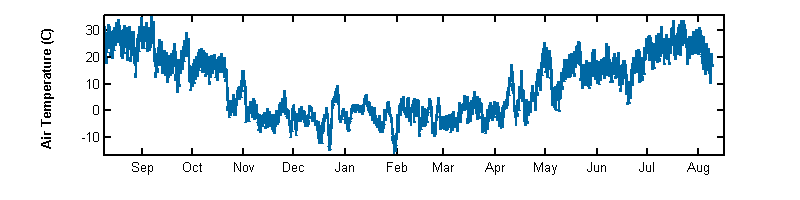

# Lower Weather 1150 (Site 2)
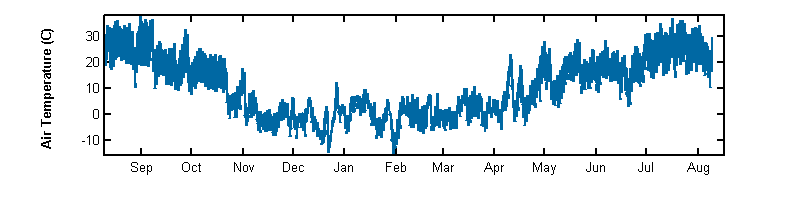

# Shingle Creek Ridge 1720 (Site 5) 
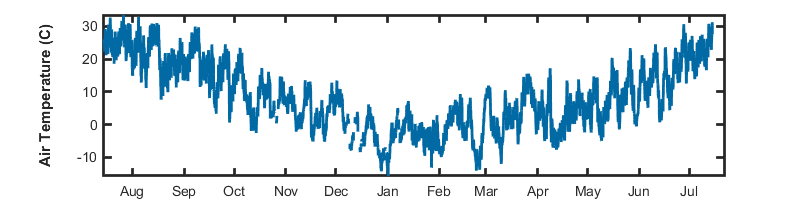

# Bogus Ridge 2114 (Site 9)
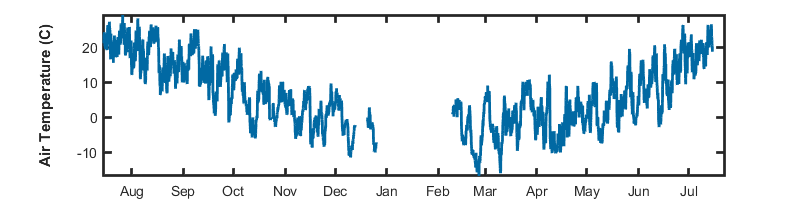